<a href="https://colab.research.google.com/github/PhilipPfeffer/haptic_vest/blob/main/data_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Pipeline

Go to the "Create Dataset" heading to create a new dataset with the desired categories and threshold.

#Import Data

In [120]:
from pycocotools.coco import COCO     # https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/coco.py
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import random
# import pylab


In [121]:
def create_coco(path_to_instances_file, datasetName='val2017'):
  # annotations=f'/content/drive/My Drive/Haptic Vest/coco_dataset/annotations/instances_{datasetName}.json'
  annotations=f'{path_to_instances_file}instances_{datasetName}.json'
  print(annotations)
  
  # This line loads annotations from an instances_{datasetName}.json file into a COCO object so we can use the pycoco API
  coco = COCO(annotations)
  return coco

#USAGE
datasetName='val2017'
path_to_instances_file ='/content/drive/My Drive/Haptic Vest/coco_dataset/annotations/'
coco = create_coco(path_to_instances_file, datasetName)

/content/drive/My Drive/Haptic Vest/coco_dataset/annotations/instances_val2017.json
loading annotations into memory...
Done (t=0.47s)
creating index...
index created!


In [122]:
# Display COCO categories and supercategories
#  - catIds: are numbers associated with each category (e.g. 1 = person, person, 2 = vehicle, bicycle, ...)
#  - cats: are the names of each category
def get_cats(coco):
  catIds = coco.getCatIds()
  cats = coco.loadCats(catIds)

  category_names = [cat['name'] for cat in cats]
  print(f"There are {len(category_names)} categories.")
  print(f"COCO categories: \n{' '.join(category_names)}\n")

  supercategory_names = set([cat['supercategory'] for cat in cats])
  print(f"There are {len(supercategory_names)} supercategories.")
  print(f"COCO supercategories: \n{' '.join(supercategory_names)}")

  return catIds, category_names, supercategory_names

# USAGE
catIds, category_names, supercategory_names = get_cats(coco)

There are 80 categories.
COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

There are 12 supercategories.
COCO supercategories: 
electronic accessory food sports appliance kitchen person furniture indoor animal vehicle outdoor


In [123]:
####################################################
# Helper function that gets the category name 
# given its id.
####################################################
def get_cat_name(category_names, cat_id=1):
  return category_names[cat_id-1]

get_cat_name(category_names, 1)

'person'

# Sort data

## Get images of a chosen category

In [124]:
####################################################
# Choosing a category:
# USAGE: get_chosen_cat_data(coco, cat_name)
# 1. Gets all the images in the dataset that have a
#    given category.
# 2. Gets all the annotations of that category in 
#    those images.
# 3. Also gets other stuff, look at the last line
####################################################

def get_chosen_cat_id(coco, cat_name='person'):
  chosen_cat_id = coco.getCatIds(catNms=[cat_name])[0];   # returns 1 for 'person'
  return chosen_cat_id

def get_chosen_cat_img_ids(coco, chosen_cat_id):
  chosen_cat_img_ids = coco.getImgIds(catIds=chosen_cat_id)
  return chosen_cat_img_ids

def get_chosen_annotation_ids(coco, chosen_cat_img_ids, chosen_cat_id):
  chosen_cat_annotation_ids = coco.getAnnIds(imgIds=chosen_cat_img_ids, catIds=chosen_cat_id)
  return chosen_cat_annotation_ids

def get_chosen_cat_annotations(coco, chosen_cat_annotation_ids):
  chosen_cat_annotations = coco.loadAnns(chosen_cat_annotation_ids)
  return chosen_cat_annotations

def get_chosen_cat_img_data(coco, chosen_cat_img_ids):
  chosen_cat_imgs_data = coco.loadImgs(chosen_cat_img_ids)
  return chosen_cat_imgs_data

def get_chosen_cat_data(coco, dataset_name, chosen_cat_name='person'):
  chosen_cat_id = get_chosen_cat_id(coco, chosen_cat_name)
  chosen_cat_img_ids = get_chosen_cat_img_ids(coco, chosen_cat_id)
  chosen_cat_imgs_data = get_chosen_cat_img_data(coco, chosen_cat_img_ids)
  chosen_cat_annotation_ids = get_chosen_annotation_ids(coco, chosen_cat_img_ids, chosen_cat_id)
  chosen_cat_annotations = get_chosen_cat_annotations(coco, chosen_cat_annotation_ids)
  print(f"\nThere are {len(chosen_cat_img_ids)} images with a {chosen_cat_name} in them in the \"{dataset_name}\" dataset.")
  print(f"Within those images, there are {len(chosen_cat_annotations)} {chosen_cat_name} annotations.")    # Note: there are more annotations than images because each image has >1 annotation
  return (chosen_cat_id, chosen_cat_img_ids, chosen_cat_imgs_data, chosen_cat_annotation_ids, chosen_cat_annotations)

# USAGE
chosen_cat_id, chosen_cat_img_ids, chosen_cat_imgs_data, chosen_cat_annotation_ids, chosen_cat_annotations = get_chosen_cat_data(coco, dataset_name, 'person')


There are 2693 images with a person in them in the "train2017" dataset.
Within those images, there are 11004 person annotations.


In [125]:
####################################################
# Checks that all the annotations are one category
# Haha, might be broken -- I tried 'cat' and it gave 'dog'
####################################################

def check_all_anns_cat(person_annotations, category_names, cat_id=1):
  if cat_id ==0:
    print("\n[ERROR]: We don't check for backgrounds, you're passing cat_id = 0.")

  cat_name = get_cat_name(category_names, cat_id)
  not_cat = False
  for ann in person_annotations: 
    if (ann['category_id'] != cat_id): 
      not_cat = True
      break
  if not_cat:
    print(f"\n[ERROR]: One of the annotations is not a {cat_name}.")
  else:
    print(f"\nYay! All of the annotations are a {cat_name}.")

# USAGE
check_all_anns_cat(chosen_cat_annotations, category_names, chosen_cat_id)


Yay! All of the annotations are a person.


In [148]:
####################################################
# Get images of all people with an area percentage
####################################################
# Variables to play with: threshold percentage area
area_pct_threshold = 0.05
####################################################
def get_ann_area(ann):
  return ann['area']

def get_img_area(img_id):
  img_data = get_chosen_cat_img_data[[img_id]]
  height = img_data['height']
  width = img_data['width']
  return height*width

def get_imgs_area(chosen_cat_imgs_data):
  imgs_area = {}
  for img_data in chosen_cat_imgs_data:
    id = img_data['id']
    height = img_data['height']
    width = img_data['width']
    imgs_area[id] = height*width
  return imgs_area

def get_img_ann_pct_area(chosen_cat_imgs_data, chosen_cat_annotations):
  imgs_area = get_imgs_area(chosen_cat_imgs_data)
  imgs_pct_area = {}
  for ann in chosen_cat_annotations:
    img_id = ann['image_id']
    img_area = imgs_area[img_id]
    ann_id = ann['id']
    ann_area = ann['area']
    pct_area = ann_area / img_area
    if pct_area > 1:
      print(f"\n[ERROR]: The percent area of annotation {ann_id} in image {img_id} is more than 100%.")
      print(f"         Annotation area given by COCO: {ann_area}")
      print(f"         Image area: {img_area}")
      print(f"         Percentage Area: {np.round(pct_area,2)*100}%")
      # break
    
    if img_id not in imgs_pct_area:
      imgs_pct_area[img_id] = [(ann_id, pct_area)]
    else:
      imgs_pct_area[img_id] += [(ann_id, pct_area)]
  
  if sum([len(ann_areas) for ann_areas in imgs_pct_area.values()]) != len(chosen_cat_annotations):
    print(f"\n[ERROR]: Some of the annotations were lost in action.")
  
  return imgs_pct_area


def get_threshold_imgs(imgs_ann_pct_area, threshold=0.05):
  threshold_imgs_pct_area = {}
  for img_id, ann_pct_list in imgs_ann_pct_area.items():
    for ann_id, ann_pct in ann_pct_list:
      if ann_pct >= threshold:
        if img_id not in threshold_imgs_pct_area:
          threshold_imgs_pct_area[img_id] = [(ann_id, ann_pct)]
        else:
          threshold_imgs_pct_area[img_id] += [(ann_id, ann_pct)]

  print(f"\nThere are {len(threshold_imgs_pct_area)} images with annotations exceeding {threshold*100}% of the image.")
  return threshold_imgs_pct_area

# USAGE
imgs_ann_pct_area = get_img_ann_pct_area(chosen_cat_imgs_data, chosen_cat_annotations)
threshold_imgs_pct_area = get_threshold_imgs(imgs_ann_pct_area, area_pct_threshold)


There are 3194 images with annotations exceeding 5.0% of the image.


In [127]:
####################################################
# Returns dict of {'image_id': [(ann_id, ann_pct_area), ...]} where each ann_pct_area exceeds the given threshold
####################################################

def get_threshold_imgs_with_anns(chosen_cat_imgs_data, chosen_cat_annotations, threshold=0.05):
  imgs_ann_pct_area = get_img_ann_pct_area(chosen_cat_imgs_data, chosen_cat_annotations)
  threshold_imgs_pct_area = get_threshold_imgs(imgs_ann_pct_area, threshold)
  return threshold_imgs_pct_area

# USAGE
threshold_imgs_with_anns = get_threshold_imgs_with_anns(chosen_cat_imgs_data, chosen_cat_annotations, area_pct_threshold)


There are 1565 images with annotations exceeding 5.0% of the image.




Processing image [1/4]
Processing image [2/4]
Processing image [3/4]
Processing image [4/4]


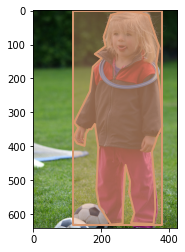

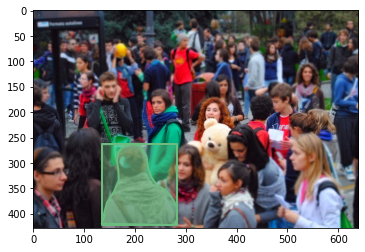

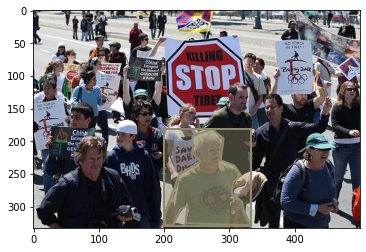

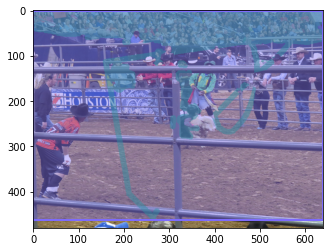

In [128]:
####################################################
# Shows random images from threshold_imgs_with_anns
####################################################

def show_rand_imgs(coco, threshold_imgs_with_anns, num_imgs_to_show=2):
  print("\n")
  thresh_list = list(threshold_imgs_with_anns.items())
  random.shuffle(thresh_list)
  for i, (img_id, anns) in enumerate(dict(thresh_list).items()):
    if i == num_imgs_to_show:
      break
    print(f"Processing image [{i+1}/{num_imgs_to_show}]")
    threshold_img_data = coco.loadImgs(img_id)[0]
    threshold_img = io.imread(threshold_img_data['coco_url'])
    plt.figure(i)
    plt.imshow(threshold_img)
    cat_annotation = get_chosen_cat_annotations(coco, anns[0][0])
    coco.showAnns(cat_annotation, draw_bbox=True)
  plt.show()

# USAGE
show_rand_imgs(coco, threshold_imgs_with_anns, num_imgs_to_show=4)

In [129]:
####################################################
# Example of loading an image from the URL [COMMENTED]
####################################################
# np.random.seed(10)   # for debugging purposes
# catIds = coco.getCatIds(catNms=['person']);
# imgIds = coco.getImgIds(catIds=catIds );

# # Load image with URL (using io)
# img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
# person_rand_img = io.imread(img['coco_url'])
# io.imshow(person_rand_img)

# # NOTE: Can also use matplotlib
# # plt.axis('off')
# # plt.imshow(person_rand_img)
# # plt.show()


# Create Dataset
Data set is made of `image_ids`, which can be used to get their COCO URLs.
Their labels are:
  - 0: nothing of interest
  - 1: person
  - 2: car

Using this pipeline you can add categories as you wish.

In [130]:
# Get COCO dataset information using 'instances_{dataset_name}.json'
dataset_name = 'train2017'
path_to_instances_file ='/content/drive/My Drive/Haptic Vest/coco_dataset/annotations/'
coco = create_coco(path_to_instances_file, dataset_name)

/content/drive/My Drive/Haptic Vest/coco_dataset/annotations/instances_train2017.json
loading annotations into memory...
Done (t=15.61s)
creating index...
index created!


In [149]:
chosen_category_names = ['person', 'traffic light', 'cat']
catIds, category_names, supercategory_names = get_cats(coco)
area_pct_threshold = 0.05
show = False

for chosen_cat_name in chosen_category_names:
  print("\n============================================")
  print(f"You requested the {chosen_cat_name} category")
  print("============================================")
  chosen_cat_id, chosen_cat_img_ids, chosen_cat_imgs_data, chosen_cat_annotation_ids, chosen_cat_annotations = get_chosen_cat_data(coco, dataset_name, chosen_cat_name)
  check_all_anns_cat(chosen_cat_annotations, category_names, chosen_cat_id)
  threshold_imgs_with_anns = get_threshold_imgs_with_anns(chosen_cat_imgs_data, chosen_cat_annotations, area_pct_threshold)
  if show:
    show_rand_imgs(coco, threshold_imgs_with_anns, num_imgs_to_show=4)


There are 80 categories.
COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

There are 12 supercategories.
COCO supercategories: 
electronic accessory food sports appliance kitchen person furniture indoor animal vehicle outdoor

You requested the person category

There are 64115 images with a person in them in the "train2017" dataset.
Within those images, there are 262465 person annotations.

Yay! All of the 

#Resize and Convert to Greyscale

In [100]:
from skimage.color import rgb2gray
from skimage.transform import resize

In [101]:
# grey96 = rgb2gray(resize(person_rand_img, (96,96)))
# io.imshow(grey96)
# np.array(grey96).shape

NameError: ignored